# **Improving the Model**

**priorities:**
- maximize accuracy
- strongly penalize false positives
- include a certainty score with each prediction

#### **imports**

In [507]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, average_precision_score, log_loss, fbeta_score, make_scorer, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split

In [508]:
#hide warnings theyre def not important right lol right hahahahahahahahahhahahah
import warnings
warnings.filterwarnings('ignore')

In [509]:
def apply_coloring(matrix):
    # Normalizing the matrix for color mapping
    norm_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Defining color for each element in the matrix
    color_matrix = np.zeros((matrix.shape[0], matrix.shape[1], 3))
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if i == j:  # True predictions
                color_matrix[i, j] = np.array([0, 0, 1]) * norm_matrix[i, j]  # Blue gradient
            else:       # False predictions
                color_matrix[i, j] = np.array([1, 0, 0]) * norm_matrix[i, j]  # Red gradient
    return color_matrix

#### **data**

In [510]:
training_set = pd.read_csv('../dataset/standardized_training.csv')
X_train = training_set.drop('general_two_year', axis=1)
y_train = training_set['general_two_year']

test_set = pd.read_csv('../dataset/standardized_testing.csv')
X_test = test_set.drop('general_two_year', axis=1)
y_test = test_set['general_two_year'].values

#### **scoring function to strongly penalize false positives**

In [511]:
f1_scorer = make_scorer(fbeta_score, beta=1)
f2_scorer = make_scorer(fbeta_score, beta=2)
f_half_scorer = make_scorer(fbeta_score, beta=0.5)
precision_scorer = make_scorer(precision_score)
pr_auc_scorer = make_scorer(average_precision_score)
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)


#### **hyperparameter tuning**

In [512]:
lsvm_param_grid = {
    'base_estimator__C': [0.1, 1.0, 10],
    'base_estimator__intercept_scaling': [0.1, 1.0, 10],
    'base_estimator__loss': ['hinge','squared_hinge']
}

lsvm = LinearSVC(random_state=42)
calibrated_lsvm = CalibratedClassifierCV(lsvm, cv=5)


try tuning hyperparameters with each of the scoring functions, and see which maximizes accuracy while minimizing false positives

In [513]:
f2_grid_search = GridSearchCV(estimator=calibrated_lsvm, param_grid=lsvm_param_grid, cv=5, n_jobs=-1, verbose=2, scoring=f2_scorer)
f2_grid_search.fit(X_train, y_train)
f2_lsvm = f2_grid_search.best_estimator_

f1_grid_search = GridSearchCV(estimator=calibrated_lsvm, param_grid=lsvm_param_grid, cv=5, n_jobs=-1, verbose=2, scoring=f1_scorer)
f1_grid_search.fit(X_train, y_train)
f1_lsvm = f1_grid_search.best_estimator_


f_half_grid_search = GridSearchCV(estimator=calibrated_lsvm, param_grid=lsvm_param_grid, cv=5, n_jobs=-1, verbose=2, scoring=f_half_scorer)
f_half_grid_search.fit(X_train, y_train)
f_half_lsvm = f_half_grid_search.best_estimator_

precision_grid_search = GridSearchCV(estimator=calibrated_lsvm, param_grid=lsvm_param_grid, cv=5, n_jobs=-1, verbose=2, scoring=precision_scorer)
precision_grid_search.fit(X_train, y_train)
precision_lsvm = precision_grid_search.best_estimator_

pr_auc_grid_search = GridSearchCV(estimator=calibrated_lsvm, param_grid=lsvm_param_grid, cv=5, n_jobs=-1, verbose=2, scoring=pr_auc_scorer)
pr_auc_grid_search.fit(X_train, y_train)
pr_auc_lsvm = pr_auc_grid_search.best_estimator_

log_loss_grid_search = GridSearchCV(estimator=calibrated_lsvm, param_grid=lsvm_param_grid, cv=5, n_jobs=-1, verbose=2, scoring=log_loss_scorer)
log_loss_grid_search.fit(X_train, y_train)
log_loss_lsvm = log_loss_grid_search.best_estimator_


roc_auc_grid_search = GridSearchCV(estimator=calibrated_lsvm, param_grid=lsvm_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
roc_auc_grid_search.fit(X_train, y_train)
roc_auc_lsvm = roc_auc_grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [514]:
f2_pred = f2_lsvm.predict(X_test)
f1_pred = f1_lsvm.predict(X_test)
f_half_pred = f_half_lsvm.predict(X_test)
precision_pred = precision_lsvm.predict(X_test)
pr_auc_pred = pr_auc_lsvm.predict(X_test)
log_loss_pred = log_loss_lsvm.predict(X_test)
roc_auc_pred = roc_auc_lsvm.predict(X_test)

#### **i put the cum in confusion matrices**

In [515]:
f2_matrix = confusion_matrix(y_test, f2_pred)
f1_matrix = confusion_matrix(y_test, f1_pred)
f_half_matrix = confusion_matrix(y_test, f_half_pred)
precision_matrix = confusion_matrix(y_test, precision_pred)
pr_auc_matrix = confusion_matrix(y_test, pr_auc_pred)
log_loss_matrix = confusion_matrix(y_test, log_loss_pred)
roc_auc_matrix = confusion_matrix(y_test, roc_auc_pred)

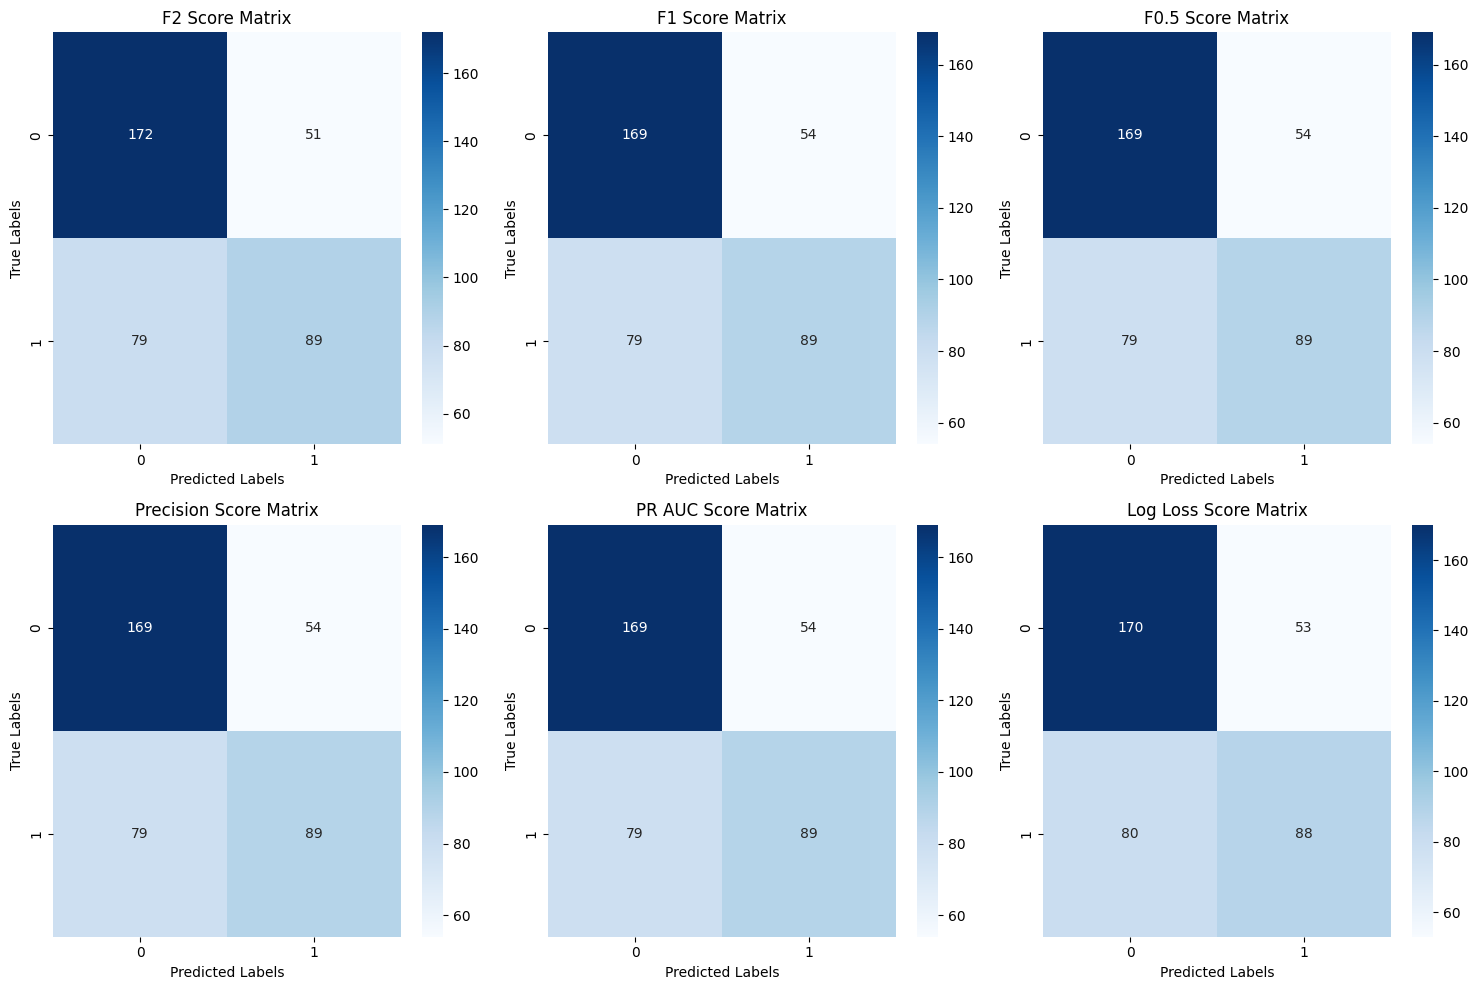

In [516]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Titles for your matrices
titles = ['F2 Score Matrix','F1 Score Matrix', 'F0.5 Score Matrix', 'Precision Score Matrix', 
          'PR AUC Score Matrix', 'Log Loss Score Matrix', 'ROC AUC Score Matrix']

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot each confusion matrix
for ax, matrix, title in zip(axes, 
                             [f2_matrix, f1_matrix, f_half_matrix, precision_matrix, pr_auc_matrix, log_loss_matrix, roc_auc_matrix], 
                             titles):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

# Adjust layout
plt.tight_layout()
plt.show()

when hyperparameters were tuned based on an f2 score, it resulted in the fewest false positives

In [517]:
y_pred = f2_lsvm.predict(X_test)
lsvm_f2 = fbeta_score(y_test, y_pred, beta=2)
print(lsvm_f2)

0.5480295566502463


#### **mess w probability threshold**

In [518]:
X_threshtrain, X_threshtest, y_threshtrain, y_threshtest = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


lsvm_param_grid = {
    'base_estimator__C': [0.1, 1.0, 10],
    'base_estimator__intercept_scaling': [0.1, 1.0, 10],
    'base_estimator__loss': ['hinge','squared_hinge']
}

lsvm = LinearSVC(random_state=42)
calibrated_lsvm = CalibratedClassifierCV(lsvm, cv=5)



In [519]:

f2_grid_search = GridSearchCV(estimator=calibrated_lsvm, param_grid=lsvm_param_grid, cv=5, n_jobs=-1, verbose=2, scoring=f2_scorer)
f2_grid_search.fit(X_threshtrain, y_threshtrain)
f2_lsvm = f2_grid_search.best_estimator_


y_threshprob = f2_lsvm.predict_proba(X_threshtest)[:, 1] 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


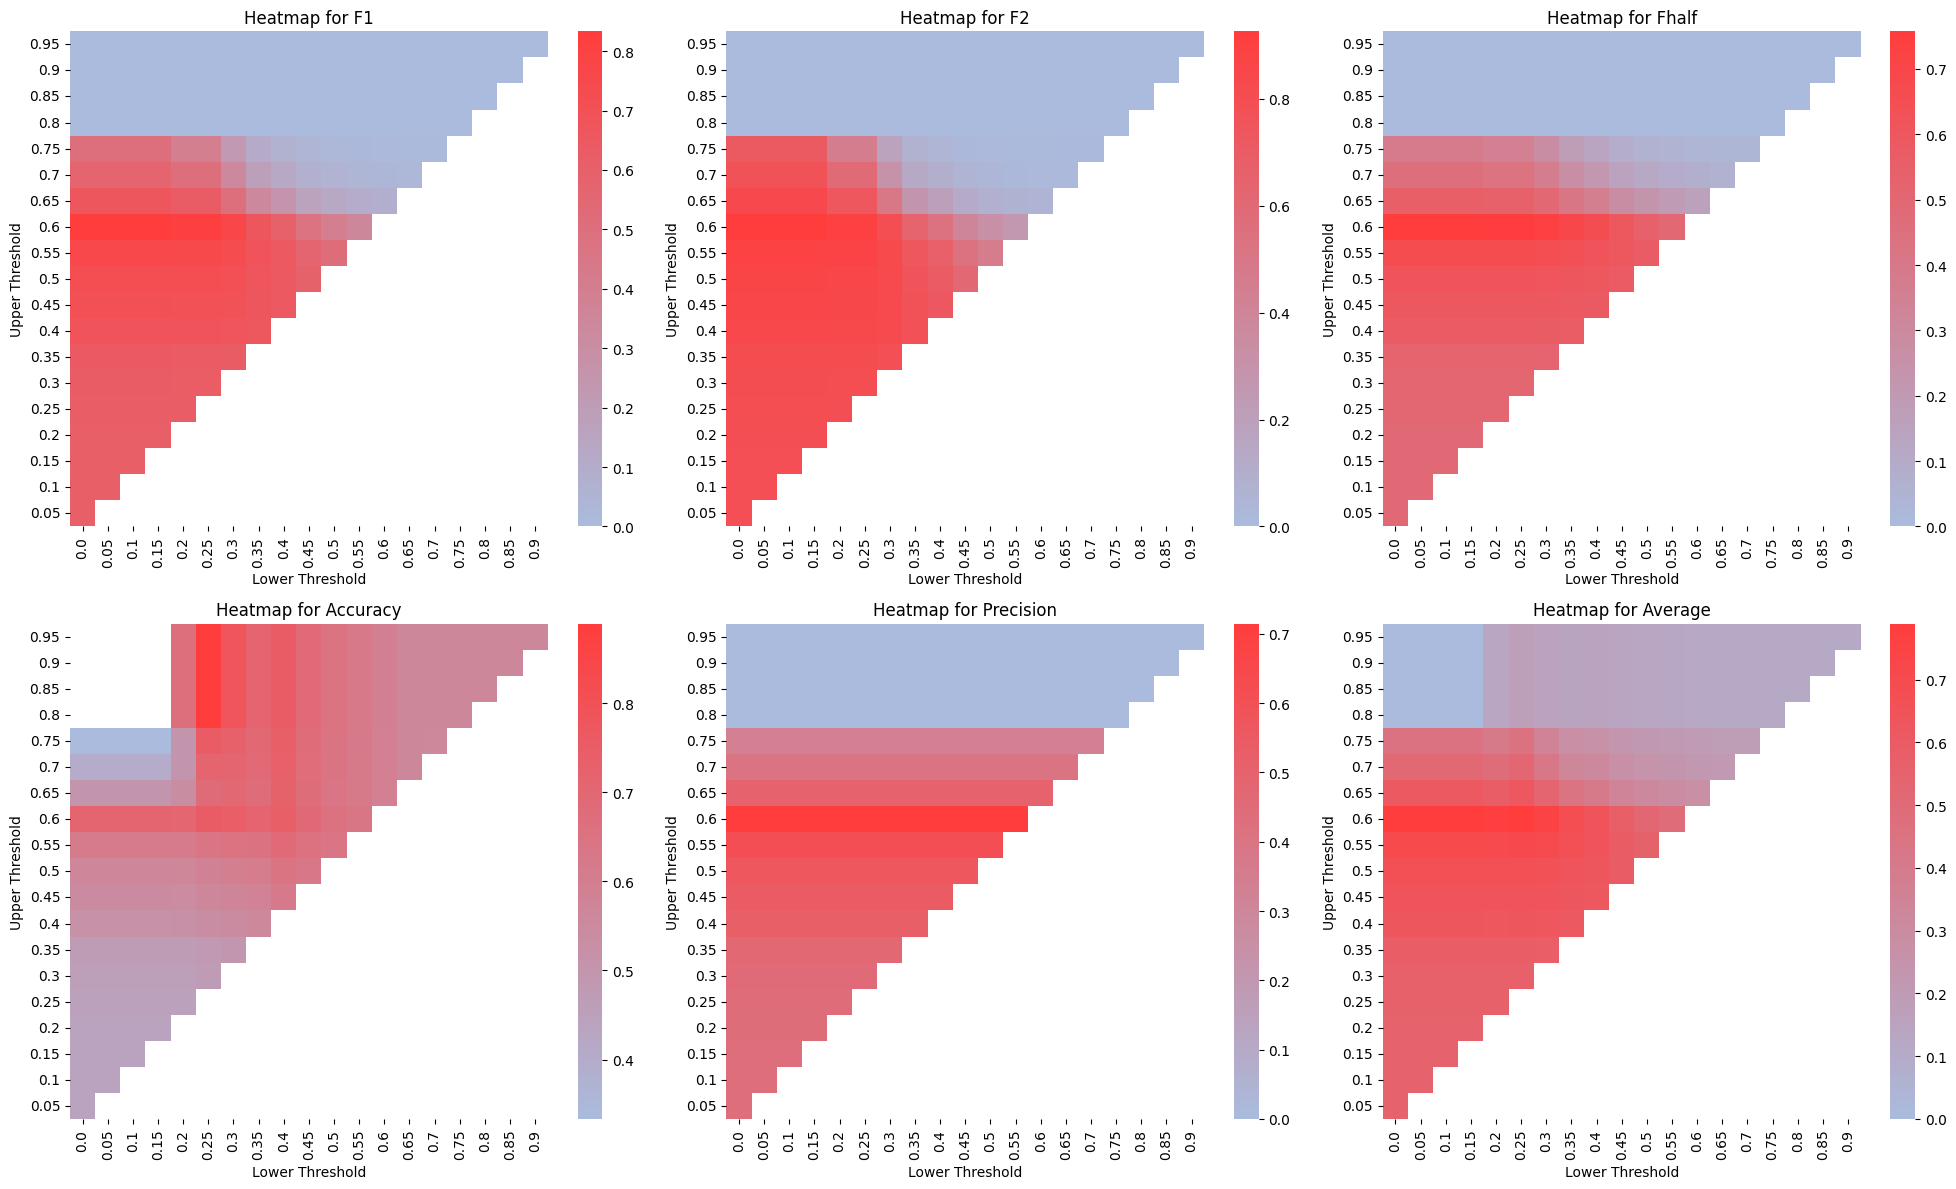

In [520]:
#find best probability thresholds

thresholds = np.arange(0, 1, 0.05)
thresholds = np.round(thresholds, 2)

results=[]


for lower in thresholds:
    for upper in thresholds:
        if lower<upper:
    
            y_pred_modified = np.empty(y_threshprob.shape, dtype=object)
            y_pred_modified[y_threshprob >= upper] = 1
            y_pred_modified[y_threshprob <= lower] = 0
            y_pred_modified[(y_threshprob > lower) & (y_threshprob < upper)] = "unknown"


            definite_mask = y_pred_modified != "unknown"
            mod_predictions = np.array(y_pred_modified[definite_mask], dtype=int)
            mod_labels = y_threshtest[definite_mask]


            # Calculate metrics
            f1 = fbeta_score(mod_labels, mod_predictions, beta=1)
            f2 = fbeta_score(mod_labels, mod_predictions, beta=2)
            fhalf = fbeta_score(mod_labels, mod_predictions, beta=0.5)
            accuracy = accuracy_score(mod_labels, mod_predictions)
            precision = precision_score(mod_labels, mod_predictions)

            results.append({"Upper": upper, "Lower": lower, "F1": f1, "F2": f2, "Fhalf": fhalf, "Accuracy": accuracy, "Precision": precision})

results_df = pd.DataFrame(results)
results_df['Average'] = results_df[['F1', 'F2', 'Fhalf', 'Accuracy', 'Precision']].mean(axis=1)


# Create a heatmap

# Define the metrics
metrics = ["F1", "F2", "Fhalf", "Accuracy", "Precision", "Average"]

# Create a colormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ['#aabbdd', '#ff3d3d'])



# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))


# Generate heatmaps
for i, metric in enumerate(metrics):
    # Pivot the DataFrame for the heatmap
    heatmap_data = results_df.pivot(index='Upper', columns='Lower', values=metric)

    row = i // 3
    col = i % 3
    
    # Create the heatmap
    sns.heatmap(heatmap_data, ax=axes[row][col], cmap=cmap, annot=False)
    axes[row][col].set_title(f"Heatmap for {metric}")
    axes[row][col].set_xlabel("Lower Threshold")
    axes[row][col].set_ylabel("Upper Threshold")

    # Invert y-axis to start with 0 at the bottom
    axes[row][col].invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.show()

on average, scores highest where upper=0.8 and lower=0.15

I'm trying to minimize false POSITIVES, so i should ask the model to be more aggressive with the upper bound of uncertainty than the lower bound. so if the upper bound is 0.8, I don't want to make the lower bound any less than 0.2 -- I don't want to require greater certainty to designate negatives than to designate positives. 

In [521]:
lower=0.15
upper=0.8

if lower<(1-upper):
    lower=np.round(1-upper, 2)

print(lower,upper)

0.2 0.8


**train and evaluate model using best scoring, and only regarding predictions with a sufficient confidence value**

In [522]:
f2_grid_search.fit(X_train, y_train)
f2_lsvm = f2_grid_search.best_estimator_

y_pred = f2_lsvm.predict(X_test)
y_prob = f2_lsvm.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [523]:
modified_y_pred = np.empty(y_prob.shape, dtype=object)
modified_y_pred[y_prob >= upper] = 1
modified_y_pred[y_prob <= lower] = 0
modified_y_pred[(y_prob > lower) & (y_prob < upper)] = "unknown"

mask = modified_y_pred != "unknown"
masked_pred = np.array(modified_y_pred[mask], dtype=int)
masked_test = y_test[mask]

In [524]:
y_count = len(y_test)
masked_count = y_count-len(masked_test)
#masked_count = np.sum(y_pred == "unknown")

masked_rate = masked_count/y_count
print("fraction of values predicted:", (1-masked_rate)*100)

fraction of values predicted: 0.7672634271099765


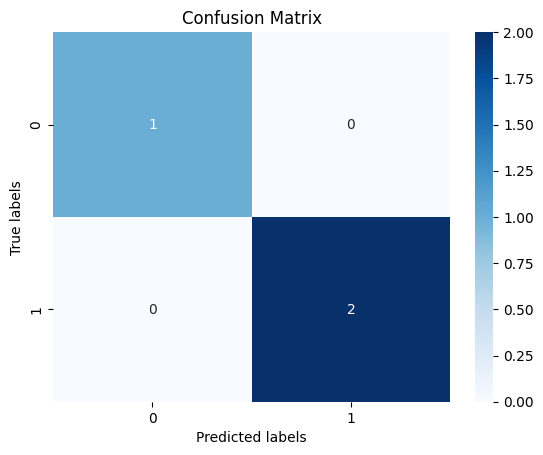

1.0


In [525]:
matrix = confusion_matrix(masked_test, masked_pred)
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print(accuracy_score(masked_test,masked_pred))

**make predictions with a range of thresholds, ranging from the previous one (which requires incredibly high certainty) to 0.5**

Upper threshold: 0.9, Lower threshold: 0.1
Fraction of values predicted: 0.00%
No predictions to evaluate for this threshold
--------------------------------------------------
Upper threshold: 0.8, Lower threshold: 0.2
Fraction of values predicted: 0.77%


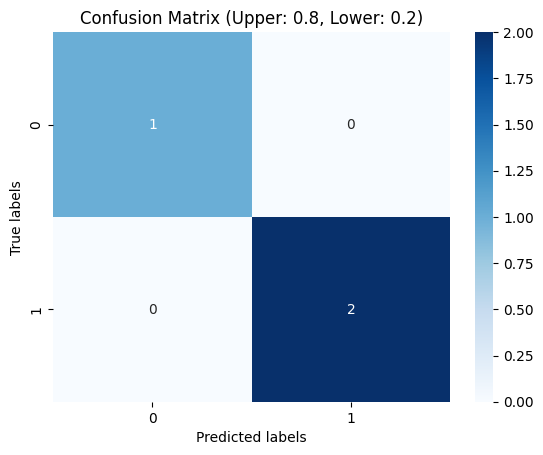

Accuracy: 1.00
--------------------------------------------------
Upper threshold: 0.7, Lower threshold: 0.3
Fraction of values predicted: 11.76%


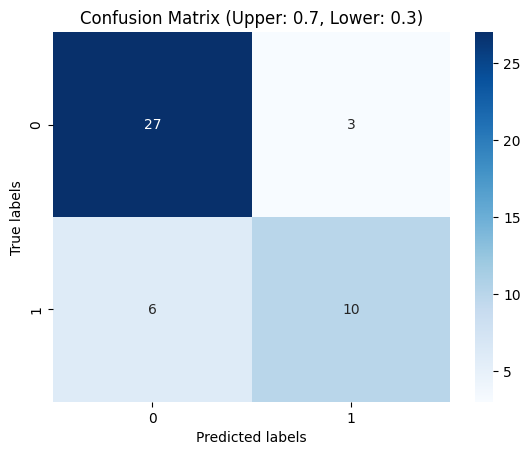

Accuracy: 0.80
--------------------------------------------------
Upper threshold: 0.6, Lower threshold: 0.4
Fraction of values predicted: 48.59%


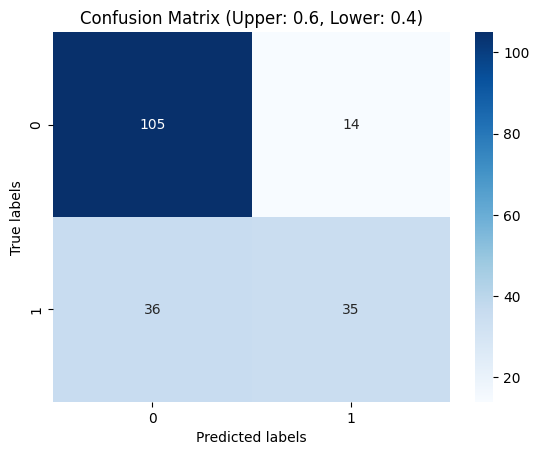

Accuracy: 0.74
--------------------------------------------------
Upper threshold: 0.5, Lower threshold: 0.5
Fraction of values predicted: 100.00%


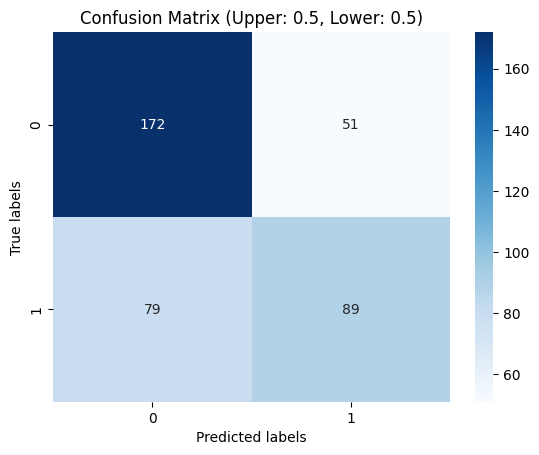

Accuracy: 0.67
--------------------------------------------------


In [527]:
thresholds = np.arange(0.1, 0.6, 0.1)

for threshold in thresholds:
    lower=np.round(threshold, 1)
    upper=np.round(1-threshold, 1)
    
    modified_y_pred = np.empty(y_prob.shape, dtype=object)
    modified_y_pred[y_prob >= upper] = 1
    modified_y_pred[y_prob <= lower] = 0
    modified_y_pred[(y_prob > lower) & (y_prob < upper)] = "unknown"

    mask = modified_y_pred != "unknown"
    masked_pred = np.array(modified_y_pred[mask], dtype=int)
    masked_test = y_test[mask]

    y_count = len(y_test)
    masked_count = y_count - len(masked_test)
    masked_rate = masked_count / y_count

    print(f"Upper threshold: {upper}, Lower threshold: {lower}")
    print(f"Fraction of values predicted: {(1 - masked_rate) * 100:.2f}%")

    # Confusion Matrix and Accuracy Score
    if len(masked_pred) > 0 and len(masked_test) > 0:  # Check if there are predictions to evaluate
        matrix = confusion_matrix(masked_test, masked_pred)
        accuracy = accuracy_score(masked_test, masked_pred)
        
        # Plotting the confusion matrix
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f'Confusion Matrix (Upper: {upper}, Lower: {lower})')
        plt.show()

        print(f"Accuracy: {accuracy:.2f}")
    else:
        print("No predictions to evaluate for this threshold")
    
    print("--------------------------------------------------")

to make predictions with high confidence, only consider values with probabilities <.2 or >.8. accuracy decreased by 33% by the time you get to the 0.5 threshold. 